In [1]:
################################################################################
#  SIMPLE TUNDISH MIXING MODEL OF CONTINUOUS CASTING DURING A GRADE TRANSITION
#           Myung Jing CHO and In Cheol KIM, ISIJ, 2006, n. 10
#
#  IMPLEMENTATION OF THE 
#
#               TUDISH MIXING MODEL (TMM)
#
#
# Rev. 03
#
#
################################################################################


class bcolors:
    HEADER    = '\033[95m'
    OKBLUE    = '\033[94m'
    OKGREEN   = '\033[92m'
    WARNING   = '\033[93m'
    FAIL      = '\033[91m'
    ENDC      = '\033[0m'
    BOLD      = '\033[1m'
    UNDERLINE = '\033[4m'

################################################################################
#                         OBTAIN THE STARTING VALUES
# Step 0:
################################################################################

##
## parameters used for the TMM (Tundish Mixing Model)
##

# mass of the tundish (max_value) [kg]
M_td_max  = 30 * 1000
# mass of the tundish (min_value reached during the change of ladle) [kg]
M_td_min  = 22 * 1000
# mass of the tundish (initial value) [kg]
M_td      = 30 * 1000
# time increment [s]
dt        = .1
# casting speed [m/min]
c_speed   = 0.45
# section diameter [m]
diam      = 405 / 1000 
# number of strands
n_strands = 4
# in-flow mass flow rate [m3/s]
Q_in      = 0                                 #initial condition: slide gate is closed
# density of the new steel grade [kg/m3]
rho_new    = 7650 
# density of the old steel grade [kg/m3]
rho_old   = 7660 
# inlet concentration 
C_in      = 1
# outlet concentration
C_out     = 0
# average concentration inside the tundish (initial value)
C_ave     = 0
# optimized scale factor
f_opt     = 1



################################################################################
#                       COMPUTE ADDITIONAL QUANTITIES
################################################################################

##
## TMM
##

# density of the steel coming out from the tundish
rho_out = rho_old         # initialization

# casting speed [m/s]
cast_speed = c_speed / 60


import math
section = math.pi * (diam / 2)**2
# out-flow mass flow rate for a single tundish exit [m3/s/strand]
Q_out_j = section * cast_speed
# total out-flow mass [m3/s]
Q_out = Q_out_j * n_strands



################################################################################
#                   CREATE THE LISTS USED TO PLOT RESULTS
# (DS implementation detail: List comprehension was used)
# https://docs.python.org/3.6/tutorial/datastructures.html
################################################################################
t = []        
t.append(0)                         # initial time set to zero s

tundish_mass = []                   
tundish_mass.append(M_td)

steel_density_out = []
steel_density_out.append(rho_out)

concentration_out = []               
concentration_out.append(C_out)

concentration_ave = []  
concentration_ave.append(C_ave)

flow_rate_in = []
flow_rate_in.append(Q_in)

flow_rate_out = []
flow_rate_out.append(Q_out)

################################################################################
#                       COMPUTE ADDITIONAL QUANTITIES
################################################################################
def info_time():
    print(bcolors.BOLD + bcolors.FAIL +
          "*** TIME INFO ***\n" + bcolors.ENDC + bcolors.UNDERLINE +
          "current simulation time (t): %.1f [s] - %.1f [min],\
time increment (dt): %.1f [s]\nnumber of time steps: %d" % 
          (t[-1], t[-1]/60, dt, len(t)) + 
         bcolors.ENDC)

def info_tundish():
    print(bcolors.BOLD + bcolors.FAIL +
          "*** TUNDISH INFO ***\n" + bcolors.ENDC + bcolors.UNDERLINE +
          "M_td: %.1f [kg], M_td_max: %.1f [kg], M_td_min: %.1f [kg]" % 
          (M_td, M_td_max, M_td_min) + 
          bcolors.ENDC)

def info_caster():
    print(bcolors.BOLD + bcolors.FAIL +
          "*** CASTER INFO ***\n" + bcolors.ENDC + bcolors.UNDERLINE +
          "cast speed: %.2f [m/min], cast_speed: %.5f [m/s],\
section diameter: %.3f [m], number of strands: %d" % 
          (c_speed, cast_speed, diam, n_strands) + 
          bcolors.ENDC)

def info_flow_rate():
     print(bcolors.BOLD + bcolors.FAIL +
          "*** FLOW RATE INFO ***\n" + bcolors.ENDC + bcolors.UNDERLINE +
          "Q_in: %.6f [m3/s], Q_out_j: %.6f [m3/s/strand], Q_out: %.6f [m3/s]" % 
          (Q_in, Q_out_j, Q_out) + 
          bcolors.ENDC)

def info_density():
     print(bcolors.BOLD + bcolors.FAIL +
          "*** DENSITY INFO ***\n" + bcolors.ENDC + bcolors.UNDERLINE +
          "rho_new: %.1f, rho_old: %.1f, rho_out: %.1f" % 
          (rho_new, rho_old, rho_out) + 
          bcolors.ENDC)

def info_concentration():
     print(bcolors.BOLD + bcolors.FAIL +
          "*** CONCENTRATION INFO ***\n" + bcolors.ENDC + bcolors.UNDERLINE +
          "C_in: %.1f, C_out: %.1f, C_ave: %.1f" % 
          (C_in, C_out, C_ave) + 
          bcolors.ENDC)

def info_f():
     print(bcolors.BOLD + bcolors.FAIL +
          "*** F INFO ***\n" + bcolors.ENDC + bcolors.UNDERLINE +
          "f: %.1f" % 
          (f_opt) + 
          bcolors.ENDC)


################################################################################
#                     DEFINITION OF THE FUNCTIONS
################################################################################
def M_td_fun(dt, M_td, rho_new, rho_out, Q_in, Q_out):
    """update the mass of the tundish"""
    M_td = M_td + (rho_new * Q_in * dt) - (Q_out * rho_out * dt)
    tundish_mass.append(M_td)
    return M_td

def rho_out_fun(C_out, rho_new, rho_out):
    """update the density of the outcoming steel"""
    rho_out = C_out * rho_new + (1 - C_out) * rho_old
    steel_density_out.append(rho_out)
    return rho_out

def C_ave_fun(dt, M_td, Q_in, Q_out, C_in, C_out, C_ave, rho_new, rho_out):
    """update the average conentration value"""
    C_ave = (M_td * C_ave + Q_in * rho_new * dt * C_in) / M_td - \
            (Q_out * rho_out * dt * C_out) / M_td
    concentration_ave.append(C_ave)
    return C_ave

def C_out_fun(f_opt, C_ave, C_in, C_out):
    """update the output concentration"""
    C_out = f_opt * C_ave + (1 - f_opt) * C_in
    concentration_out.append(C_out)
    return C_out

def flow_rate_update(Q_in, Q_out):
    flow_rate_in.append(Q_in)
    flow_rate_out.append(Q_out)
    


################################################################################
#                          PRINT THE START CONDITIONS
################################################################################
info_f()
info_caster()
info_flow_rate()
info_density()
info_time()
info_tundish()
info_concentration()


################################################################################
#                            RUN THE SIMULATION CASE
#
################################################################################


################################################################################
#               TUNDISH EMPTYING ( DURING LADLE CHANGE )
################################################################################
print(bcolors.BOLD + bcolors.WARNING + "\n Emptying the tundish,\
\nQ_in: %.6f [m3/s], Q_out: %.6f [m3/s]\n" % (Q_in, Q_out) + bcolors.ENDC)

#for x in range (n_time_step):
while ( M_td > M_td_min ):
    # Step 2:
    M_td = M_td_fun(dt, M_td, rho_new, rho_out, Q_in, Q_out)
    rho_out = rho_out_fun(C_out, rho_new, rho_out)
    # Step 3:
    C_ave = C_ave_fun(dt, M_td, Q_in, Q_out, C_in, C_out, C_ave, rho_new, rho_out)
    # Step 4:
    C_out = C_out_fun(f_opt, C_ave, C_in, C_out)
    # Step 5:
    flow_rate_update(Q_in, Q_out)
    t.append(t[-1] + dt)  


info_time()
info_flow_rate()
info_tundish()
info_concentration()

time_to_empty_the_tundish = t[-1]
print(bcolors.BOLD + bcolors.OKGREEN + "\n Tundish emptying time: %.1f [s] = %.1f [min] "
      % (time_to_empty_the_tundish, time_to_empty_the_tundish/60) + bcolors.ENDC)


################################################################################
#               TUNDISH FILLING AFTER LADLE CHANGE
################################################################################
# in-flow mass flow rate [m3/s]
Q_in = 0.012 # filling flow rate

print(bcolors.BOLD + bcolors.WARNING + "\n Filling the tundish to the max tundish weigth,\
\nQ_in: %.6f [m3/s], Q_out: %.6f [m3/s]\n" % (Q_in, Q_out) + bcolors.ENDC)

while ( M_td < M_td_max ):
    # Step 2:
    M_td = M_td_fun(dt, M_td, rho_new, rho_out, Q_in, Q_out)
    rho_out = rho_out_fun(C_out, rho_new, rho_out)
    # Step 3:
    C_ave = C_ave_fun(dt, M_td, Q_in, Q_out, C_in, C_out, C_ave, rho_new, rho_out)
    # Step 4:
    C_out = C_out_fun(f_opt, C_ave, C_in, C_out)
    # Step 5:
    flow_rate_update(Q_in, Q_out)
    t.append(t[-1] + dt)   
    
    

info_time()
info_flow_rate()
info_tundish()
info_concentration()

time_to_fill_the_tundish = t[-1] - time_to_empty_the_tundish
print(bcolors.BOLD + bcolors.OKGREEN + "\n Tundish filling time: %.1f [s] = %.1f [min] \n"
      % (time_to_fill_the_tundish, time_to_fill_the_tundish/60) +  bcolors.ENDC)

################################################################################
#               MEET THE FINAL CONCENTRATION 0.7
################################################################################
# in-flow mass flow rate [m3/s]
Q_in = Q_out # steady state
# target concentration value to meet
C_target = 0.7

print(bcolors.BOLD + bcolors.WARNING + "\n Meet the C_target concentation of %.1f,\
\nQ_in: %.6f [m3/s], Q_out: %.6f [m3/s]\n" % (C_target, Q_in, Q_out) + bcolors.ENDC)

while ( C_out < C_target ):
    # Step 2:
    M_td = M_td_fun(dt, M_td, rho_new, rho_out, Q_in, Q_out)
    rho_out = rho_out_fun(C_out, rho_new, rho_out)
    # Step 3:
    C_ave = C_ave_fun(dt, M_td, Q_in, Q_out, C_in, C_out, C_ave, rho_new, rho_out)
    # Step 4:
    C_out = C_out_fun(f_opt, C_ave, C_in, C_out)
    # Step 5:
    flow_rate_update(Q_in, Q_out)
    t.append(t[-1] + dt)  
    
    

info_time()
info_flow_rate()
info_tundish()
info_concentration()

time_to_reach_the_final_conc_1 = t[-1] - time_to_empty_the_tundish - time_to_fill_the_tundish
print(bcolors.BOLD + bcolors.OKGREEN + 
      "\n time to reach the final concentration of %.1f: %.1f [s] = %.1f [min] \n" 
      % (C_target, time_to_reach_the_final_conc_1, time_to_reach_the_final_conc_1/60) +
     bcolors.ENDC)


################################################################################
#               MEET THE FINAL CONCENTRATION 0.9
################################################################################
# in-flow mass flow rate [m3/s]
Q_in = Q_out # steady state
# target concentration value to meet
C_target = 0.9

print(bcolors.BOLD + bcolors.WARNING + "\n Meet the C_target concentation of %.1f,\
\nQ_in: %.6f [m3/s], Q_out: %.6f [m3/s]\n" % (C_target, Q_in, Q_out) + bcolors.ENDC)

while ( C_out < C_target ):
    # Step 2:
    M_td = M_td_fun(dt, M_td, rho_new, rho_out, Q_in, Q_out)
    rho_out = rho_out_fun(C_out, rho_new, rho_out)
    # Step 3:
    C_ave = C_ave_fun(dt, M_td, Q_in, Q_out, C_in, C_out, C_ave, rho_new, rho_out)
    # Step 4:
    C_out = C_out_fun(f_opt, C_ave, C_in, C_out)
    # Step 5:
    flow_rate_update(Q_in, Q_out)
    t.append(t[-1] + dt)   
    

info_time()
info_flow_rate()
info_tundish()
info_concentration()

time_to_reach_the_final_conc_2 = t[-1] - time_to_empty_the_tundish - time_to_fill_the_tundish - \
                                     time_to_reach_the_final_conc_1
print(bcolors.BOLD + bcolors.OKGREEN + 
      "\n time to reach the final concentration of %.1f: %.1f [s] = %.1f [min] \n" 
      % (C_target, time_to_reach_the_final_conc_2, time_to_reach_the_final_conc_2/60) +
     bcolors.ENDC )

################################################################################
#               MEET THE FINAL CONCENTRATION 0.99
################################################################################
# in-flow mass flow rate [m3/s]
Q_in = Q_out # steady state
# target concentration value to meet
C_target = 0.99

print(bcolors.BOLD + bcolors.WARNING + "\n Meet the C_target concentation of %.1f,\
\nQ_in: %.6f [m3/s], Q_out: %.6f [m3/s]\n" % (C_target, Q_in, Q_out) + bcolors.ENDC)

while ( C_out < C_target ):
    # Step 2:
    M_td = M_td_fun(dt, M_td, rho_new, rho_out, Q_in, Q_out)
    rho_out = rho_out_fun(C_out, rho_new, rho_out)
    # Step 3:
    C_ave = C_ave_fun(dt, M_td, Q_in, Q_out, C_in, C_out, C_ave, rho_new, rho_out)
    # Step 4:
    C_out = C_out_fun(f_opt, C_ave, C_in, C_out)
    # Step 5:
    flow_rate_update(Q_in, Q_out)
    t.append(t[-1] + dt)  
    

info_time()
info_flow_rate()
info_tundish()
info_concentration()

time_to_reach_the_final_conc_3 = t[-1] - time_to_empty_the_tundish - time_to_fill_the_tundish - \
                                     time_to_reach_the_final_conc_1 - time_to_reach_the_final_conc_2
print(bcolors.BOLD + bcolors.OKGREEN + 
      "\n time to reach the final concentration of %.2f: %.1f [s] = %.1f [min] \n" 
      % (C_target, time_to_reach_the_final_conc_3, time_to_reach_the_final_conc_3/60) +
     bcolors.ENDC )

*** F INFO ***
f: 1.0
*** CASTER INFO ***
cast speed: 0.45 [m/min], cast_speed: 0.00750 [m/s],section diameter: 0.405 [m], number of strands: 4
*** FLOW RATE INFO ***
Q_in: 0.000000 [m3/s], Q_out_j: 0.000966 [m3/s/strand], Q_out: 0.003865 [m3/s]
*** DENSITY INFO ***
rho_new: 7650.0, rho_old: 7660.0, rho_out: 7660.0
*** TIME INFO ***
current simulation time (t): 0.0 [s] - 0.0 [min],time increment (dt): 0.1 [s]
number of time steps: 1
*** TUNDISH INFO ***
M_td: 30000.0 [kg], M_td_max: 30000.0 [kg], M_td_min: 22000.0 [kg]
*** CONCENTRATION INFO ***
C_in: 1.0, C_out: 0.0, C_ave: 0.0

 Emptying the tundish,
Q_in: 0.000000 [m3/s], Q_out: 0.003865 [m3/s]

*** TIME INFO ***
current simulation time (t): 270.3 [s] - 4.5 [min],time increment (dt): 0.1 [s]
number of time steps: 2704
*** FLOW RATE INFO ***
Q_in: 0.000000 [m3/s], Q_out_j: 0.000966 [m3/s/strand], Q_out: 0.003865 [m3/s]
*** TUNDISH INFO ***
M_td: 21998.0 [kg], M_td_max: 30000.0 [kg], M_td_min: 22000.0 [kg]
*** CONCENTRATION INFO ***
C

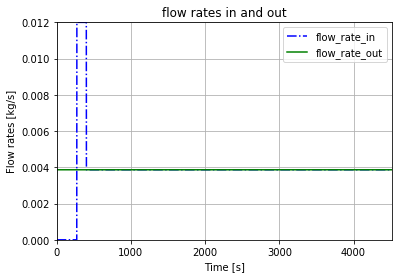

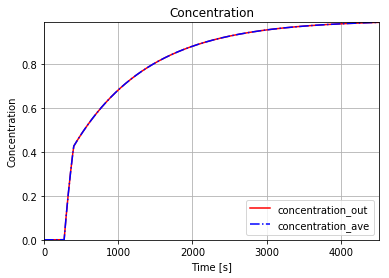

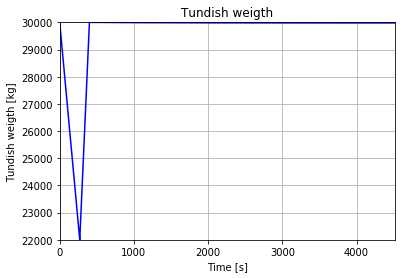

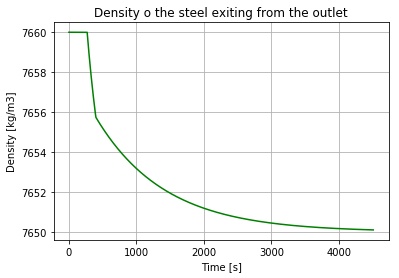

In [2]:
import matplotlib.pyplot as plt

def max_of_two_lists(la, lb):
    return max(max(la), max(lb))

plt.figure(1)
plt.title('flow rates in and out')
line, = plt.plot(t, flow_rate_in, '-.b', label='flow_rate_in')
line, = plt.plot(t, flow_rate_out, '-g', label='flow_rate_out')
plt.ylabel('Flow rates [kg/s]')
plt.xlabel('Time [s]')
plt.axis([0, t[-1], 0, max_of_two_lists(flow_rate_in, flow_rate_out)])
plt.legend()
plt.grid()
plt.show()

plt.figure(2)
plt.title('Concentration')
plt.plot(t, concentration_out , 'r', label='concentration_out')
plt.plot(t, concentration_ave , '-.b', label='concentration_ave')
plt.ylabel('Concentration')
plt.xlabel('Time [s]')
plt.axis([0, t[-1], 0, max_of_two_lists(concentration_out, concentration_ave)])
plt.legend()
plt.grid()
plt.show()

plt.figure(3)
plt.title('Tundish weigth')
plt.plot(t, tundish_mass , 'b')
plt.ylabel('Tundish weigth [kg]')
plt.xlabel('Time [s]')
plt.axis([0, t[-1], M_td_min, max(tundish_mass)])
plt.grid()
plt.show()

plt.figure(4)
plt.title('Density o the steel exiting from the outlet')
plt.plot(t, steel_density_out , 'g')
plt.ylabel('Density [kg/m3]')
plt.xlabel('Time [s]')
#plt.axis([0, t[-1], rho_old, max(steel_density_out)])
plt.grid()
plt.show()


working path:  e:\Users\NigroL\Desktop\Untitled Folder 



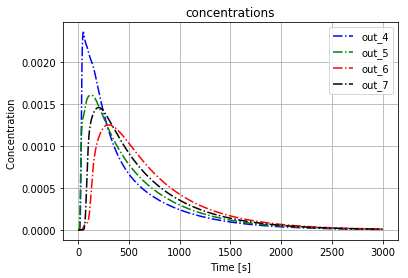

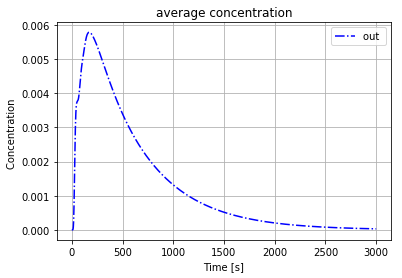

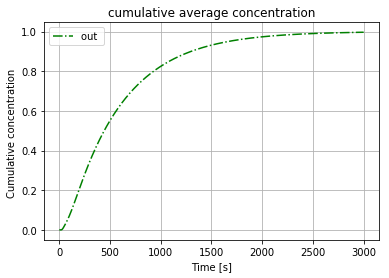

In [17]:
import os
import sys
import csv
import numpy as np        # cumulative sum over lists

# get the current working path
cwd = os.getcwd()
print("working path: ", cwd, "\n")


path = cwd + '\out4.out'
with open(path, 'r') as f:
    reader = csv.reader(f,delimiter=" ")
    for column in zip(*[line for line in csv.reader(f, delimiter=" ")]):
        data_4 = list(column)
       

path = cwd + '\out5.out'    
with open(path, 'r') as f:
    reader = csv.reader(f,delimiter=" ")
    for column in zip(*[line for line in csv.reader(f, delimiter=" ")]):
        data_5 = list(column)  
    

path = cwd + '\out6.out'    
with open(path, 'r') as f:
    reader = csv.reader(f,delimiter=" ")
    for column in zip(*[line for line in csv.reader(f, delimiter=" ")]):
        data_6 = list(column)

        
path = cwd + '\out7.out'    
with open(path, 'r') as f:
    reader = csv.reader(f,delimiter=" ")
    for column in zip(*[line for line in csv.reader(f, delimiter=" ")]):
        data_7 = list(column)
        
#close the file stream
f.close()


data_4 = [float(x) for x in data_4]
data_5 = [float(x) for x in data_5]
data_6 = [float(x) for x in data_6]
data_7 = [float(x) for x in data_7]

n_data = len(data_4)
time = list(range(0,n_data))

#print(type(time[1]), type(data[1]))

plt.figure(5)
plt.title('concentrations')
line, = plt.plot(time, data_4, '-.b', label='out_4')
line, = plt.plot(time, data_5, '-.g', label='out_5')
line, = plt.plot(time, data_6, '-.r', label='out_6')
line, = plt.plot(time, data_7, '-.k', label='out_7')
plt.ylabel('Concentration ')
plt.xlabel('Time [s]')
plt.legend()
plt.grid()
plt.show()


data = [sum(x) for x in zip(data_4, data_5, data_6, data_7)]


plt.figure(6)
plt.title('average concentration')
line, = plt.plot(time, data, '-.b', label='out ')
plt.ylabel('Concentration ')
plt.xlabel('Time [s]')
plt.legend()
plt.grid()
plt.show()


data_cum = np.cumsum(data)
data_cum_max = max(data_cum)
data_cum_normalized  = [x / 4. for x in data_cum]

plt.figure(6)
plt.title('cumulative average concentration')
line, = plt.plot(time, data_cum_normalized, '-.g', label='out ')
plt.ylabel('Cumulative concentration ')
plt.xlabel('Time [s]')
plt.legend()
plt.grid()
plt.show()